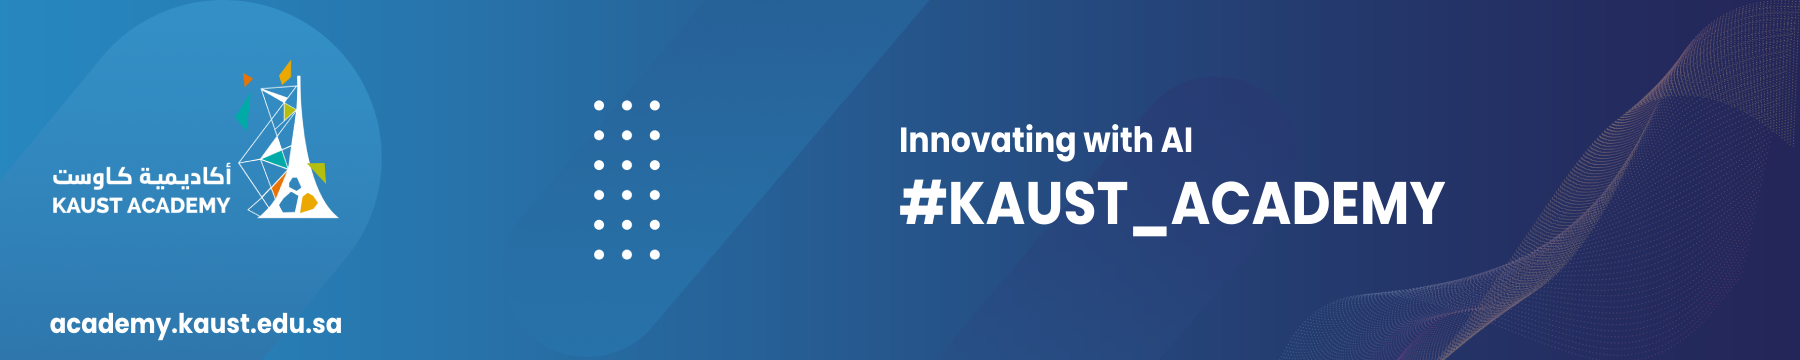

# 🐌 Unsloth: Fast & Efficient Fine-Tuning of LLMs

**Unsloth** is an open-source library designed to fine-tune Large Language Models (LLMs) like **LLaMA**, **Mistral**, and **Gemma** with:

- 🧠 Low memory usage
- ⚡ High speed
- ✅ Full support for PEFT (e.g., LoRA, QLoRA)

---

## 🔧 Key Features

- ⚡ Built on [Flash Attention](https://github.com/HazyResearch/flash-attention)
- 🧱 Supports LLaMA, Mistral, Gemma, etc.
- 🧠 LoRA/QLoRA integration
- 💻 Runs on 12GB GPUs or Google Colab

---

## 🔍 ⚡ Why Flash Attention?

Traditional attention computes an $O(n^2)$ matrix, which becomes expensive for long sequences.
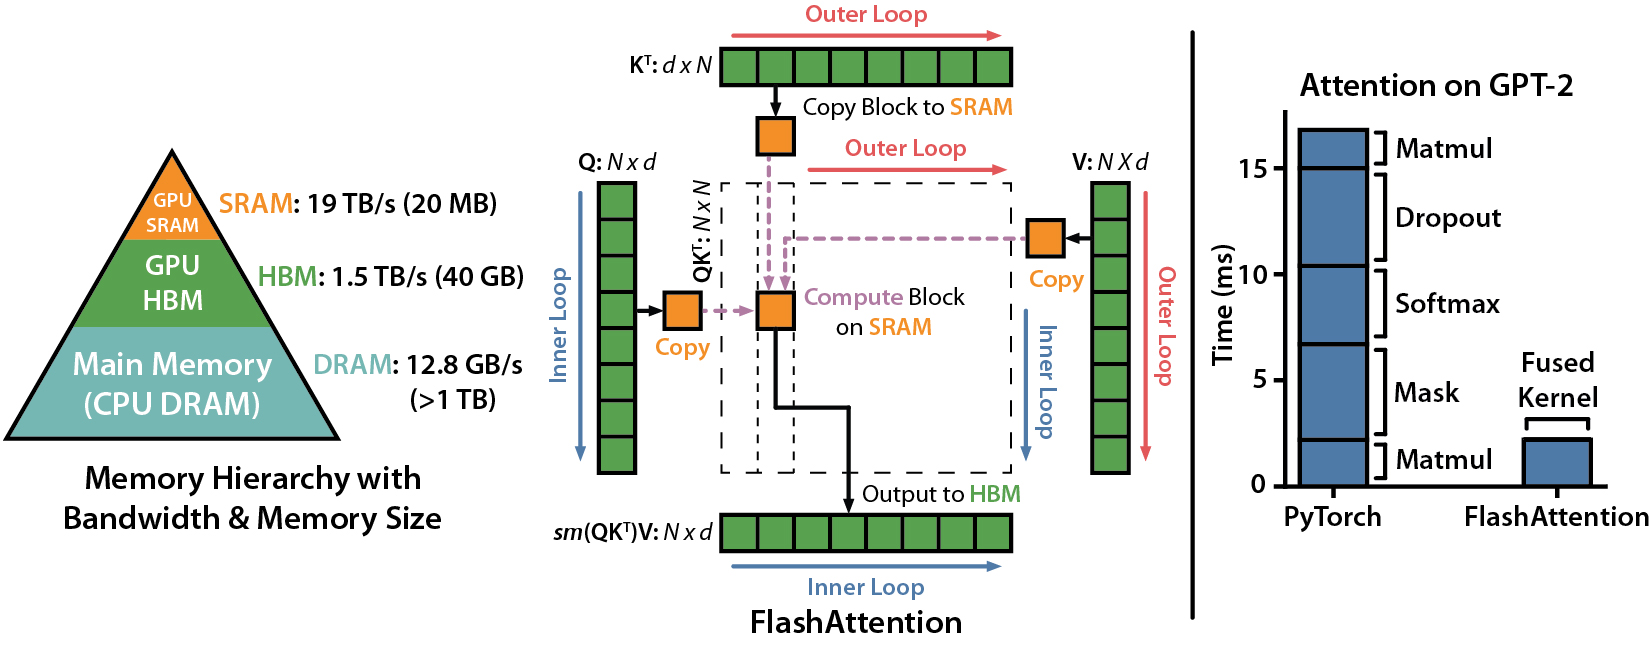


To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://docs.unsloth.ai/get-started/installing-+-updating).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)


### Installation

In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth vllm
else:
    # [NOTE] Do the below ONLY in Colab! Use [[pip install unsloth vllm]]
    !pip install --no-deps unsloth vllm==0.8.5.post1

In [ ]:
#@title Colab Extra Install { display-mode: "form" }
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth vllm
else:
    !pip install --no-deps unsloth vllm==0.8.5.post1
    # [NOTE] Do the below ONLY in Colab! Use [[pip install unsloth vllm]]
    # Skip restarting message in Colab
    import sys, re, requests; modules = list(sys.modules.keys())
    for x in modules: sys.modules.pop(x) if "PIL" in x or "google" in x else None
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer

    # vLLM requirements - vLLM breaks Colab due to reinstalling numpy
    f = requests.get("https://raw.githubusercontent.com/vllm-project/vllm/refs/heads/main/requirements/common.txt").content
    with open("vllm_requirements.txt", "wb") as file:
        file.write(re.sub(rb"(transformers|numpy|xformers)[^\n]{1,}\n", b"", f))
    !pip install -r vllm_requirements.txt

Goal: To convert `Qwen3-4B-Base` into a reasoning model via GRPO by using OpenR1's Math dataset.

We first pre fine-tune the model to make GRPO skip trying to match formatting - this speeds GRPO up.

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Can increase for longer reasoning traces
lora_rank = 32 # Larger rank = smarter, but slower

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen3-4B-Base",
    max_seq_length = max_seq_length,
    load_in_4bit = False, # False for LoRA 16bit
    fast_inference = True, # Enable vLLM fast inference
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.7, # Reduce if out of memory
)

model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
    lora_alpha = lora_rank*2, # *2 speeds up training
    use_gradient_checkpointing = "unsloth", # Reduces memory usage
    random_state = 3407,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 05-26 00:48:35 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 05-26 00:48:36 [__init__.py:239] Automatically detected platform cuda.
==((====))==  Unsloth 2025.5.7: Fast Qwen3 patching. Transformers: 4.51.3. vLLM: 0.8.5.post1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/Qwen3-4B-Base with actual GPU utilization = 69.34%
Unsloth: Your GPU has CUDA compute capability 7.5 with VRAM = 14.74 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 2048

tokenizer_config.json:   0%|          | 0.00/5.43k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

INFO 05-26 00:49:05 [cuda.py:240] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 05-26 00:49:05 [cuda.py:289] Using XFormers backend.
INFO 05-26 00:49:05 [parallel_state.py:1004] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0
INFO 05-26 00:49:05 [model_runner.py:1108] Starting to load model unsloth/Qwen3-4B-Base...
INFO 05-26 00:49:06 [weight_utils.py:265] Using model weights format ['*.safetensors']


model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

INFO 05-26 00:50:41 [weight_utils.py:281] Time spent downloading weights for unsloth/Qwen3-4B-Base: 95.117292 seconds


model.safetensors.index.json:   0%|          | 0.00/32.8k [00:00<?, ?B/s]

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 05-26 00:51:13 [loader.py:458] Loading weights took 32.11 seconds
INFO 05-26 00:51:13 [punica_selector.py:18] Using PunicaWrapperGPU.
INFO 05-26 00:51:14 [model_runner.py:1140] Model loading took 7.6334 GiB and 128.041393 seconds
INFO 05-26 00:51:25 [worker.py:287] Memory profiling takes 10.05 seconds
INFO 05-26 00:51:25 [worker.py:287] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.69) = 10.22GiB
INFO 05-26 00:51:25 [worker.py:287] model weights take 7.63GiB; non_torch_memory takes 0.03GiB; PyTorch activation peak memory takes 0.88GiB; the rest of the memory reserved for KV Cache is 1.68GiB.
INFO 05-26 00:51:25 [executor_base.py:112] # cuda blocks: 764, # CPU blocks: 0
INFO 05-26 00:51:25 [executor_base.py:117] Maximum concurrency for 2048 tokens per request: 5.97x
INFO 05-26 00:51:25 [model_runner.py:1450] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mo

Capturing CUDA graph shapes:   0%|          | 0/23 [00:00<?, ?it/s]

INFO 05-26 00:52:08 [model_runner.py:1592] Graph capturing finished in 43 secs, took 0.34 GiB
INFO 05-26 00:52:08 [llm_engine.py:437] init engine (profile, create kv cache, warmup model) took 53.82 seconds
Unsloth: Just some info: will skip parsing ['post_feedforward_layernorm', 'pre_feedforward_layernorm']
Unsloth: Just some info: will skip parsing ['post_feedforward_layernorm', 'pre_feedforward_layernorm']


tokenizer_config.json:   0%|          | 0.00/5.43k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Unsloth 2025.5.7 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


### GRPO chat template
Since we're using a base model, we should set a chat template. You can make your own chat template as well!
1. DeepSeek uses `<think>` and `</think>`, but this is **not** necessary - you can customize it however you like!
2. A `system_prompt` is recommended to at least guide the model's responses.

In [ ]:
reasoning_start = "<start_working_out>" # Acts as <think>
reasoning_end   = "<end_working_out>"   # Acts as </think>
solution_start  = "<SOLUTION>"
solution_end    = "</SOLUTION>"

system_prompt = \
f"""You are given a problem.
Think about the problem and provide your working out.
Place it between {reasoning_start} and {reasoning_end}.
Then, provide your solution between {solution_start}{solution_end}"""
system_prompt

'You are given a problem.\nThink about the problem and provide your working out.\nPlace it between <start_working_out> and <end_working_out>.\nThen, provide your solution between <SOLUTION></SOLUTION>'

We create a simple chat template below. Notice `add_generation_prompt` includes prepending `<start_working_out>` to guide the model to start its reasoning process.

In [ ]:
chat_template = \
    "{% if messages[0]['role'] == 'system' %}"\
        "{{ messages[0]['content'] + eos_token }}"\
        "{% set loop_messages = messages[1:] %}"\
    "{% else %}"\
        "{{ '{system_prompt}' + eos_token }}"\
        "{% set loop_messages = messages %}"\
    "{% endif %}"\
    "{% for message in loop_messages %}"\
        "{% if message['role'] == 'user' %}"\
            "{{ message['content'] }}"\
        "{% elif message['role'] == 'assistant' %}"\
            "{{ message['content'] + eos_token }}"\
        "{% endif %}"\
    "{% endfor %}"\
    "{% if add_generation_prompt %}{{ '{reasoning_start}' }}"\
    "{% endif %}"

# Replace with out specific template:
chat_template = chat_template\
    .replace("'{system_prompt}'",   f"'{system_prompt}'")\
    .replace("'{reasoning_start}'", f"'{reasoning_start}'")
tokenizer.chat_template = chat_template

Let's see how our chat template behaves on an example:

In [ ]:
tokenizer.apply_chat_template([
    {"role" : "user", "content" : "What is 1+1?"},
    {"role" : "assistant", "content" : f"{reasoning_start}I think it's 2.{reasoning_end}{solution_start}2{solution_end}"},
    {"role" : "user", "content" : "What is 2+2?"},
], tokenize = False, add_generation_prompt = True)

"You are given a problem.\nThink about the problem and provide your working out.\nPlace it between <start_working_out> and <end_working_out>.\nThen, provide your solution between <SOLUTION></SOLUTION><|endoftext|>What is 1+1?<start_working_out>I think it's 2.<end_working_out><SOLUTION>2</SOLUTION><|endoftext|>What is 2+2?<start_working_out>"

### Pre fine-tuning for formatting
We now use a subset of NVIDIA's [Open Math Reasoning dataset](https://huggingface.co/datasets/nvidia/OpenMathReasoning) which was filtered to only include high quality DeepSeek R1 traces.

We'll only filter ~59 or so examples to first "prime" / pre fine-tune the model to understand our custom GRPO formatting.

In [ ]:
from datasets import load_dataset
import pandas as pd
import numpy as np

dataset = load_dataset("unsloth/OpenMathReasoning-mini", split = "cot")
dataset = dataset.to_pandas()[
    ["expected_answer", "problem", "generated_solution"]
]

# Try converting to number - if not, replace with NaN
is_number = pd.to_numeric(pd.Series(dataset["expected_answer"]), errors = "coerce").notnull()
# Select only numbers
dataset = dataset.iloc[np.where(is_number)[0]]

dataset

README.md:   0%|          | 0.00/603 [00:00<?, ?B/s]

data/cot-00000-of-00001.parquet:   0%|          | 0.00/106M [00:00<?, ?B/s]

Generating cot split:   0%|          | 0/19252 [00:00<?, ? examples/s]

,expected_answer,problem,generated_solution
0,14,Given $\sqrt{x^2+165}-\sqrt{x^2-52}=7$ and $x$...,"<think>\nOkay, let's see. I need to solve the ..."
6,-2,Find the value of the parameter $a$ for which ...,"<think>\nOkay, so I need to find the value of ..."
9,18,What is the sum of all real numbers $x$ for wh...,"<think>\nOkay, so I need to solve the equation..."
13,2,Evaluate the sum \(\sum_{n=1}^\infty \frac{\ph...,"<think>\nOkay, so I need to evaluate the infin..."
17,30,What is the largest positive integer that divi...,"<think>\nAlright, so I need to find the larges..."
...,...,...,...
19243,244,"Let \( p \), \( q \), and \( r \) be the disti...","<think>\nOkay, so I need to find the value of ..."
19245,1,A bug is on the $0$ of a number line. At any p...,"<think>\nOkay, so I have this problem where a ..."
19247,4,A bus left point X for point Y. Two hours late...,"<think>\nOkay, let's tackle this problem step ..."
19248,18,Each interior angle of a regular n-gon measure...,"<think>\nOkay, let's see. I need to find the n..."


We have to format the dataset to follow our GRPO style formatting:

In [ ]:
def format_dataset(x):
    expected_answer = x["expected_answer"]
    problem = x["problem"]

    # Remove generated <think> and </think>
    thoughts = x["generated_solution"]
    thoughts = thoughts.replace("<think>", "").replace("</think>", "")

    # Strip newlines on left and right
    thoughts = thoughts.strip()
    # Add our custom formatting
    final_prompt = \
        reasoning_start + thoughts + reasoning_end + \
        solution_start + expected_answer + solution_end
    return [
        {"role" : "system",    "content" : system_prompt},
        {"role" : "user",      "content" : problem},
        {"role" : "assistant", "content" : final_prompt},
    ]

dataset["Messages"] = dataset.apply(format_dataset, axis = 1)

Check to see if it worked:

In [ ]:
tokenizer.apply_chat_template(dataset["Messages"][0], tokenize = False)

"You are given a problem.\nThink about the problem and provide your working out.\nPlace it between <start_working_out> and <end_working_out>.\nThen, provide your solution between <SOLUTION></SOLUTION><|endoftext|>Given $\\sqrt{x^2+165}-\\sqrt{x^2-52}=7$ and $x$ is positive, find all possible values of $x$.<start_working_out>Okay, let's see. I need to solve the equation √(x² + 165) - √(x² - 52) = 7, and find all positive values of x. Hmm, radicals can be tricky, but maybe if I can eliminate the square roots by squaring both sides. Let me try that.\n\nFirst, let me write down the equation again to make sure I have it right:\n\n√(x² + 165) - √(x² - 52) = 7.\n\nOkay, so the idea is to isolate one of the radicals and then square both sides. Let me try moving the second radical to the other side:\n\n√(x² + 165) = 7 + √(x² - 52).\n\nNow, if I square both sides, maybe I can get rid of the square roots. Let's do that:\n\n(√(x² + 165))² = (7 + √(x² - 52))².\n\nSimplifying the left side:\n\nx² + 

Let's truncate the pre fine-tuning dataset to `max_seq_length/2` since we don't want too long reasoning traces.

Note this might take 2 minutes!

In [ ]:
dataset["N"] = dataset["Messages"].apply(lambda x: len(tokenizer.apply_chat_template(x)))

dataset = dataset.loc[dataset["N"] <= max_seq_length/2].copy()
dataset.shape

(59, 5)

We then tokenize the messages and convert it to a Hugging Face compatible dataset format:

In [ ]:
from datasets import Dataset

dataset["text"] = tokenizer.apply_chat_template(dataset["Messages"].values.tolist(), tokenize = False)
dataset = Dataset.from_pandas(dataset)
dataset

Dataset({
    features: ['expected_answer', 'problem', 'generated_solution', 'Messages', 'N', 'text', '__index_level_0__'],
    num_rows: 59
})

Let's now pre fine-tune the model so it follows our custom GRPO formatting!

In [ ]:
from trl import SFTTrainer, SFTConfig
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    args = SFTConfig(
        dataset_text_field = "text",
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 1, # Use GA to mimic batch size!
        warmup_steps = 5,
        num_train_epochs = 2, # Set this for 1 full training run.
        learning_rate = 2e-4, # Reduce to 2e-5 for long training runs
        logging_steps = 5,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        report_to = "none", # Use this for WandB etc
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/59 [00:00<?, ? examples/s]

In [ ]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 59 | Num Epochs = 2 | Total steps = 118
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 1 x 1) = 1
 "-____-"     Trainable parameters = 66,060,288/4,088,528,384 (1.62% trained)


Step,Training Loss
5,0.644900
10,0.639600
15,0.419300
20,0.389600
25,0.422200
30,0.448400
35,0.475100
40,0.419100
45,0.445300
50,0.328000


Unsloth: Will smartly offload gradients to save VRAM!


TrainOutput(global_step=118, training_loss=0.3486394861997184, metrics={'train_runtime': 170.8892, 'train_samples_per_second': 0.691, 'train_steps_per_second': 0.691, 'total_flos': 2374193075607552.0, 'train_loss': 0.3486394861997184})

Let's check if the model has learnt to follow the custom format:

In [ ]:
text = tokenizer.apply_chat_template(
    dataset[0]["Messages"][:2],
    tokenize = False,
    add_generation_prompt = True, # Must add for generation
)

from transformers import TextStreamer
_ = model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    temperature = 0,
    max_new_tokens = 1024,
    streamer = TextStreamer(tokenizer, skip_prompt = False),
)

You are given a problem.
Think about the problem and provide your working out.
Place it between <start_working_out> and <end_working_out>.
Then, provide your solution between <SOLUTION></SOLUTION><|endoftext|>Jenifer has 82 cents in pennies and nickels. Her younger brother mistook all her nickels for dimes and counted the total as $1.47. How many pennies does Jenifer have?<start_working_out>Okay, let's see. Jenifer has 82 cents in pennies and nickels. Her brother thought all the nickels were dimes and counted the total as $1.47. I need to find out how many pennies she has. Hmm, let's break this down.

First, I need to set up some equations. Let's say the number of pennies is P and the number of nickels is N. Since pennies are worth 1 cent each and nickels are 5 cents each, the total value is P + 5N = 82 cents. That's the first equation.

Now, her brother thought all the nickels were dimes. Dimes are 10 cents each. So, he counted the total as $1.47, which is 147 cents. So, the equation 

Yes it did follow the formatting! Great! Let's remove some items before the GRPO step

In [ ]:
del dataset
torch.cuda.empty_cache()
import gc
gc.collect()

0

### Data Prep
<a name="Data"></a>

We're using Hugging Face's [Open R1 Math dataset](https://huggingface.co/datasets/open-r1/DAPO-Math-17k-Processed). You can also utilize OpenAI's famous [GSM8K dataset](https://huggingface.co/datasets/openai/gsm8k)

In [ ]:
from datasets import load_dataset
dataset = load_dataset("open-r1/DAPO-Math-17k-Processed", "en", split = "train")
dataset

README.md:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

en/train-00000-of-00001.parquet:   0%|          | 0.00/5.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14116 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'solution', 'data_source', 'source_prompt', 'ability', 'reward_model', 'extra_info'],
    num_rows: 14116
})

Let's look at the first row:

In [ ]:
dataset[0]["prompt"]

'In triangle $ABC$, $\\sin \\angle A = \\frac{4}{5}$ and $\\angle A < 90^\\circ$. Let $D$ be a point outside triangle $ABC$ such that $\\angle BAD = \\angle DAC$ and $\\angle BDC = 90^\\circ$. Suppose that $AD = 1$ and that $\\frac{BD}{CD} = \\frac{3}{2}$. If $AB + AC$ can be expressed in the form $\\frac{a\\sqrt{b}}{c}$ where $a, b, c$ are pairwise relatively prime integers, find $a + b + c$.'

In [ ]:
dataset[0]["solution"]

'34'

In GSM8K, ee notice all answers like about have a ####, so we extract it. But for the Open R1 dataset, we can skip the below.

In [ ]:
def extract_hash_answer(text):
    # if "####" not in text: return None
    # return text.split("####")[1].strip()
    return text
extract_hash_answer(dataset[0]["solution"])

'34'

Let's map the dataset! and see the first row:

In [ ]:
dataset = dataset.map(lambda x: {
    "prompt" : [
        {"role": "system", "content": system_prompt},
        {"role": "user",   "content": x["prompt"]},
    ],
    "answer": extract_hash_answer(x["solution"]),
})
dataset[0]

Map:   0%|          | 0/14116 [00:00<?, ? examples/s]

{'prompt': [{'content': 'You are given a problem.\nThink about the problem and provide your working out.\nPlace it between <start_working_out> and <end_working_out>.\nThen, provide your solution between <SOLUTION></SOLUTION>',
   'role': 'system'},
  {'content': 'In triangle $ABC$, $\\sin \\angle A = \\frac{4}{5}$ and $\\angle A < 90^\\circ$. Let $D$ be a point outside triangle $ABC$ such that $\\angle BAD = \\angle DAC$ and $\\angle BDC = 90^\\circ$. Suppose that $AD = 1$ and that $\\frac{BD}{CD} = \\frac{3}{2}$. If $AB + AC$ can be expressed in the form $\\frac{a\\sqrt{b}}{c}$ where $a, b, c$ are pairwise relatively prime integers, find $a + b + c$.',
   'role': 'user'}],
 'solution': '34',
 'data_source': 'math_dapo',
 'source_prompt': [{'content': 'Solve the following math problem step by step. The last line of your response should be of the form Answer: $Answer (without quotes) where $Answer is the answer to the problem.\n\nIn triangle $ABC$, $\\sin \\angle A = \\frac{4}{5}$ and $

We create a regex format to match the reasoning sections and answers:

In [ ]:
import re

# Add optional EOS token matching
solution_end_regex = r"</SOLUTION>[\s]{0,}" + \
    "(?:" + re.escape(tokenizer.eos_token) + ")?"

match_format = re.compile(
    rf"{reasoning_end}.*?"\
    rf"{solution_start}(.+?){solution_end_regex}"\
    rf"[\s]{{0,}}$",
    flags = re.MULTILINE | re.DOTALL
)
match_format

re.compile(r'<end_working_out>.*?<SOLUTION>(.+?)</SOLUTION>[\s]{0,}(?:<\|endoftext\|>)?[\s]{0,}$',
re.MULTILINE|re.DOTALL|re.UNICODE)

We verify it works:

In [ ]:
match_format.findall(
    "Let me think!<end_working_out>"\
    f"<SOLUTION>\n2\n</SOLUTION>",
)

['\n2\n']

In [ ]:
match_format.findall(
    "<start_working_out>Let me think!<end_working_out>"\
    f"<SOLUTION>  2  </SOLUTION>\n\n",
)

['  2  ']

We now want to create a reward function to match the format exactly - we reward it with 3 points if it succeeds:

In [ ]:
def match_format_exactly(completions, **kwargs):
    scores = []
    for completion in completions:
        score = 0
        response = completion[0]["content"]
        # Match if format is seen exactly!
        if match_format.search(response) is not None: score += 3.0
        scores.append(score)
    return scores

If it fails, we want to reward the model if it at least follows the format partially, by counting each symbol:

In [ ]:
def match_format_approximately(completions, **kwargs):
    scores = []
    for completion in completions:
        score = 0
        response = completion[0]["content"]
        # Count how many keywords are seen - we penalize if too many!
        # If we see 1, then plus some points!

        # No need to reward <start_working_out> since we always prepend it!
        # score += 0.5 if response.count(reasoning_start) == 1 else -1.0
        score += 0.5 if response.count(reasoning_end)   == 1 else -1.0
        score += 0.5 if response.count(solution_start)  == 1 else -1.0
        score += 0.5 if response.count(solution_end)    == 1 else -1.0
        scores.append(score)
    return scores

Finally, we want to extract the generated answer, and reward or penalize it! We also reward it based on how close the answer is to the true one via ratios:

In [ ]:
def check_answer(prompts, completions, answer, **kwargs):
    question = prompts[0][-1]["content"]
    responses = [completion[0]["content"] for completion in completions]

    extracted_responses = [
        guess.group(1)
        if (guess := match_format.search(r)) is not None else None \
        for r in responses
    ]

    scores = []
    for guess, true_answer in zip(extracted_responses, answer):
        score = 0
        if guess is None:
            scores.append(-2.0)
            continue
        # Correct answer gets 5 points!
        if guess == true_answer:
            score += 5.0
        # Match if spaces are seen, but less reward
        elif guess.strip() == true_answer.strip():
            score += 3.5
        else:
            # We also reward it if the answer is close via ratios!
            # Ie if the answer is within some range, reward it!
            try:
                ratio = float(guess) / float(true_answer)
                if   ratio >= 0.9 and ratio <= 1.1: score += 2.0
                elif ratio >= 0.8 and ratio <= 1.2: score += 1.5
                else: score -= 2.5 # Penalize wrong answers
            except:
                score -= 4.5 # Penalize
        scores.append(score)
    return scores

Also sometimes it might not be 1 number as the answer, but like a sentence for example "The solution is $20" -> we extract 20.

We also remove possible commas for example as in 123,456

In [ ]:
match_numbers = re.compile(
    solution_start + r".*?[\s]{0,}([-]?[\d\.\,]{1,})",
    flags = re.MULTILINE | re.DOTALL
)
print(match_numbers.findall("<SOLUTION>  0.34  </SOLUTION>"))
print(match_numbers.findall("<SOLUTION>  123,456  </SOLUTION>"))
print(match_numbers.findall("<SOLUTION>  -0.234  </SOLUTION>"))
print(match_numbers.findall("<SOLUTION>17</SOLUTION>"))

['0.34']
['123,456']
['-0.234']
['17']


We now prepare our main function which will print out the generated responses and the true answer, along with another reward function which converts text to float via `float` and sees if it's the same.

In [ ]:
global PRINTED_TIMES
PRINTED_TIMES = 0
global PRINT_EVERY_STEPS
PRINT_EVERY_STEPS = 5

def check_numbers(prompts, completions, answer, **kwargs):
    question = prompts[0][-1]["content"]
    responses = [completion[0]["content"] for completion in completions]

    extracted_responses = [
        guess.group(1)
        if (guess := match_numbers.search(r)) is not None else None \
        for r in responses
    ]

    scores = []
    # Print only every few steps
    global PRINTED_TIMES
    global PRINT_EVERY_STEPS
    if PRINTED_TIMES % PRINT_EVERY_STEPS == 0:
        print(
            '*'*20 + f"Question:\n{question}", f"\nAnswer:\n{answer[0]}", f"\nResponse:\n{responses[0]}", f"\nExtracted:\n{extracted_responses[0]}"
        )
    PRINTED_TIMES += 1

    for guess, true_answer in zip(extracted_responses, answer):
        if guess is None:
            scores.append(-2.5)
            continue
        # Convert to numbers
        try:
            true_answer = float(true_answer.strip())
            # Remove commas like in 123,456
            guess       = float(guess.strip().replace(",", ""))
            scores.append(3.5 if guess == true_answer else -1.5)
        except:
            scores.append(0)
            continue
    return scores

Get the top 90% prompt length so we don't accidentally truncate them!

Ie we'll remove the top 10% long prompts.

In [ ]:
tokenized = dataset.map(
    lambda x: {"tokens" : tokenizer.apply_chat_template(x["prompt"], add_generation_prompt = True, tokenize = True)},
    batched = True,
)
print(tokenizer.decode(tokenized[0]["tokens"]))
tokenized = tokenized.map(lambda x: {"L" : len(x["tokens"])})

import numpy as np
maximum_length = int(np.quantile(tokenized["L"], 0.9))
print("Max Length = ", maximum_length)

# Filter only samples smaller than 90% max length
dataset = dataset.select(np.where(np.array(tokenized["L"]) <= maximum_length)[0])
del tokenized

Map:   0%|          | 0/14116 [00:00<?, ? examples/s]

You are given a problem.
Think about the problem and provide your working out.
Place it between <start_working_out> and <end_working_out>.
Then, provide your solution between <SOLUTION></SOLUTION><|endoftext|>In triangle $ABC$, $\sin \angle A = \frac{4}{5}$ and $\angle A < 90^\circ$. Let $D$ be a point outside triangle $ABC$ such that $\angle BAD = \angle DAC$ and $\angle BDC = 90^\circ$. Suppose that $AD = 1$ and that $\frac{BD}{CD} = \frac{3}{2}$. If $AB + AC$ can be expressed in the form $\frac{a\sqrt{b}}{c}$ where $a, b, c$ are pairwise relatively prime integers, find $a + b + c$.<start_working_out>


Map:   0%|          | 0/14116 [00:00<?, ? examples/s]

Max Length =  201


<a name="Train"></a>
### Train the model

Now set up GRPO Trainer and all configurations!

In [ ]:
max_prompt_length = maximum_length + 1 # + 1 just in case!
max_completion_length = max_seq_length - max_prompt_length

from vllm import SamplingParams
vllm_sampling_params = SamplingParams(
    min_p = 0.1,
    top_p = 1.0,
    top_k = -1,
    seed = 3407,
    stop = [tokenizer.eos_token],
    include_stop_str_in_output = True,
)

from trl import GRPOConfig, GRPOTrainer
training_args = GRPOConfig(
    vllm_sampling_params = vllm_sampling_params,
    temperature = 1.0,
    learning_rate = 5e-6,
    weight_decay = 0.01,
    warmup_ratio = 0.1,
    lr_scheduler_type = "linear",
    optim = "adamw_8bit",
    logging_steps = 1,
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 1, # Increase to 4 for smoother training
    num_generations = 4, # Decrease if out of memory
    max_prompt_length = max_prompt_length,
    max_completion_length = max_completion_length,
    # num_train_epochs = 1, # Set to 1 for a full training run
    max_steps = 100,
    save_steps = 100,
    report_to = "none", # Can use Weights & Biases
    output_dir = "outputs",

    # For optional training + evaluation
    # fp16_full_eval = True,
    # per_device_eval_batch_size = 4,
    # eval_accumulation_steps = 1,
    # eval_strategy = "steps",
    # eval_steps = 1,
)

Unsloth: We now expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 4


And let's run the trainer! If you scroll up, you'll see a table of rewards. The goal is to see the `reward` column increase!

You might have to wait 150 to 200 steps for any action. You'll probably get 0 reward for the first 100 steps. Please be patient!

| Step | Training Loss | reward    | reward_std | completion_length | kl       |
|------|---------------|-----------|------------|-------------------|----------|
| 1    | 0.000000      | 0.125000  | 0.000000   | 200.000000        | 0.000000 |
| 2    | 0.000000      | 0.072375  | 0.248112   | 200.000000        | 0.000000 |
| 3    | 0.000000      | -0.079000 | 0.163776   | 182.500000        | 0.000005 |


In [ ]:
# For optional training + evaluation
# new_dataset = dataset.train_test_split(test_size = 0.01)

trainer = GRPOTrainer(
    model = model,
    processing_class = tokenizer,
    reward_funcs = [
        match_format_exactly,
        match_format_approximately,
        check_answer,
        check_numbers,
    ],
    args = training_args,
    train_dataset = dataset,

    # For optional training + evaluation
    # train_dataset = new_dataset["train"],
    # eval_dataset = new_dataset["test"],
)
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 12,709 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 1 x 1) = 4
 "-____-"     Trainable parameters = 66,060,288/4,088,528,384 (1.62% trained)


********************Question:
Compute the number of positive integers that divide at least two of the integers in the set $\{1^1,2^2,3^3,4^4,5^5,6^6,7^7,8^8,9^9,10^{10}\}$. 
Answer:
22 
Response:
Okay, so I need to find the number of positive integers that divide at least two of the numbers in the set {1^1, 2^2, 3^3, ..., 10^10}. Hmm, let's start by understanding what the problem is asking. We have a set where each element is a number raised to its own power, from 1 to 10. The goal is to find how many positive integers are divisors of at least two of these numbers. 

First, I think I should list out the elements of the set to see what they are. Let me compute each one:

1. 1^1 = 1
2. 2^2 = 4
3. 3^3 = 27
4. 4^4 = 256
5. 5^5 = 3125
6. 6^6 = 46656
7. 7^7 = 823543
8. 8^8 = 16777216
9. 9^9 = 387420489
10. 10^10 = 10000000000

Wait, those are all the elements. Now, I need to find all positive integers that divide at least two of these numbers. The key here is that a divisor of two numbers mu

Step,Training Loss,reward,reward_std,completion_length,kl,rewards / match_format_exactly,rewards / match_format_approximately,rewards / check_answer,rewards / check_numbers
1,0.006200,-7.500000,0.000000,1846.000000,0.155724,0.000000,-3.000000,-2.000000,-2.500000
2,0.005200,-5.500000,4.000000,1754.000000,0.130613,0.750000,-1.875000,-2.125000,-2.250000
3,0.006300,-5.500000,4.000000,1826.000000,0.156329,0.750000,-1.875000,-2.125000,-2.250000
4,0.007100,-7.500000,0.000000,1846.000000,0.176596,0.000000,-3.000000,-2.000000,-2.500000
5,0.007500,13.000000,0.000000,1297.500000,0.188479,3.000000,1.500000,5.000000,3.500000
6,0.004800,-7.500000,0.000000,1846.000000,0.119617,0.000000,-3.000000,-2.000000,-2.500000
7,0.006200,-5.500000,4.000000,1679.000000,0.154963,0.750000,-1.875000,-2.125000,-2.250000
8,0.004200,-7.500000,0.000000,1846.000000,0.105323,0.000000,-3.000000,-2.000000,-2.500000
9,0.006100,-7.500000,0.000000,1846.000000,0.152696,0.000000,-3.000000,-2.000000,-2.500000
10,0.004900,-0.875000,9.672771,1784.750000,0.123577,1.500000,-0.750000,-0.875000,-0.750000


********************Question:
The sum of $\lfloor x \rfloor$ for all real numbers $x$ satisfying the equation $16 + 15x + 15x^2 = \lfloor x \rfloor^3$ is: 
Answer:
33 
Response:
Okay, so I need to find the sum of the floor of x for all real numbers x that satisfy the equation 16 + 15x + 15x² = ⌊x⌋³. Hmm, let me think.

First, let me understand what the equation is saying. The equation relates a quadratic in x, 16 + 15x + 15x², to the cube of the floor of x. The floor function ⌊x⌋ gives the greatest integer less than or equal to x. So, for each solution x, I need to compute ⌊x⌋ and then sum those values.

Alright, let me try to find the possible values of ⌊x⌋. Since ⌊x⌋ is an integer, maybe I can denote it as n, where n is an integer. Then the equation becomes 16 + 15x + 15x² = n³.

But wait, x is a real number, but since we're taking its floor, n ≤ x < n+1. So perhaps I can substitute x with n + y, where y is the fractional part, 0 ≤ y < 1. Then the equation becomes:

16 + 15(n + y) + 

TrainOutput(global_step=100, training_loss=0.0067273743636906145, metrics={'train_runtime': 10607.693, 'train_samples_per_second': 0.038, 'train_steps_per_second': 0.009, 'total_flos': 0.0, 'train_loss': 0.0067273743636906145})

<a name="Inference"></a>
### Inference
Now let's try the model we just trained! First, let's first try the model without any GRPO trained:

In [ ]:
text = "What is the sqrt of 101?"

from vllm import SamplingParams
sampling_params = SamplingParams(
    temperature = 1.0,
    top_k = 50,
    max_tokens = 1024,
)
output = model.fast_generate(
    [text],
    sampling_params = sampling_params,
    lora_request = None,
)[0].outputs[0].text

output

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

' - Answers\nEducation\nMath and Arithmetic\nWhat is the sqrt of 101?\nWiki User\n∙ 2009-06-05 01:02:40\nBest Answer\nCopy\n10.05\nWiki User\n∙ 2009-06-05 01:02:40\nThis answer is:\n🙏\n0\n🤨\n0\n😮\n0\nWhat is the sqrt of 100?\nThe square root of 100 is 10; 10x10=100\nWhat is the Sqrt of 100?\nSqrt (100) = +10 &amp; -10 since both (+10) X (+10) and (-10) X (-\n10) equal 100\nWhat is the sqrt of 10000?\nIt is 100.\nHow many meters in a kilometer?\nThere are 1000 meters in a kilometer. 100 centimeter in a\nmeter. 1,000 meters in a km. 100cm in a meter.\nThe square root 100 is?\n-10 +10\nSqrt x equals 7 sqrt 2 find the value of x?\nSqrt(x) = 7 Sqrt(2) x = 72 x 2 x = 49 x 2 x = 98\nSqrt 100 simplified?\nSqrt(100) = 10 is its simplest form.\nWhat is the sqr root of 100?\n10 or -10 because 10*10=100\nand (-10)(-10)=100\nSqr\'s and cubs?\nSqrt(100) = 10 and 102 = 100Sqrt(1000) = 31.6 and 31.62 = 10001Sqrt(24) = 4.9 and 4.92 = 24If you are unsure, just check them out by calculator.The "cube" of 

And now with the LoRA we just trained with GRPO - we first save the LoRA first!

In [ ]:
model.save_lora("grpo_saved_lora")

Verify LoRA is actually trained!

In [ ]:
from safetensors import safe_open

tensors = {}
with safe_open("grpo_saved_lora/adapter_model.safetensors", framework = "pt") as f:
    # Verify both A and B are non zero
    for key in f.keys():
        tensor = f.get_tensor(key)
        n_zeros = (tensor == 0).sum() / tensor.numel()
        assert(n_zeros.item() != tensor.numel())

Now we load the LoRA and test:

In [ ]:
messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user",   "content": "What is the sqrt of 101?"},
]

text = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True, # Must add for generation
    tokenize = False,
)
from vllm import SamplingParams
sampling_params = SamplingParams(
    temperature = 1.0,
    top_k = 50,
    max_tokens = 2048,
)
output = model.fast_generate(
    text,
    sampling_params = sampling_params,
    lora_request = model.load_lora("grpo_saved_lora"),
)[0].outputs[0].text

output

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

"Okay, so I need to find the square root of 101. Hmm, let me think. I remember that square roots of numbers between perfect squares are irrational, meaning they can't be expressed as simple fractions. Let's see, the perfect squares around 101 are 100 and 121. Since 10² is 100 and 11² is 121, the square root of 101 must be between 10 and 11. \n\nWait, but how close is it to 10 or 11? Maybe I can estimate it a bit more. Let me try multiplying 10.05 by itself. Calculating (10.05)² would be 10.05 * 10.05. Let's break that down: 10 * 10 = 100, 10*0.05=0.5, 0.05*10=0.5, and 0.05*0.05=0.0025. Adding those up: 100 + 0.5 + 0.5 + 0.0025 = 101.0025. That's a bit more than 101. So maybe 10.05 is too high. \n\nLet me try 10.04... Let's compute (10.04)². That would be 10.04 * 10.04. Breaking it down: 100 + 40*0.04=1.6 + 0.04*0.04=0.0016. So 100 + 1.6 + 0.0016 = 101.6016. Still a bit high. So maybe 10.03. Let's try (10.03)²: 100 + 30*0.03=0.9 + 0.03*0.03=0.0009. Adding gives 100 + 0.9 + 0.0009 = 100.

Our reasoning model is much better - it's not always correct, since we only trained it for an hour or so - it'll be better if we extend the sequence length and train for longer!

<a name="Save"></a>
### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Merge to 16bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False:
    model.save_pretrained("model")
    tokenizer.save_pretrained("model")
if False:
    model.push_to_hub("hf/model", token = "")
    tokenizer.push_to_hub("hf/model", token = "")


### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

[**NEW**] To finetune and auto export to Ollama, try our [Ollama notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
# Remember to go to https://huggingface.co/settings/tokens for a token!
# And change hf to your username!
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

# Save to multiple GGUF options - much faster if you want multiple!
if False:
    model.push_to_hub_gguf(
        "hf/model", # Change hf to your username!
        tokenizer,
        quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
        token = "",
    )

---

### 📚 References & Credits

This notebook builds on tools and techniques from the [Unsloth Project](https://unsloth.ai/) and uses the [Gemma-2 9B Instruct (4-bit)](https://huggingface.co/unsloth/gemma-2-9b-it-bnb-4bit) model, made available by the Unsloth team.

For more details, see:
- 🔗 [Unsloth Documentation](https://docs.unsloth.ai/)
- 🔗 [Unsloth GitHub](https://github.com/unslothai/unsloth)
- 💬 Join their [Discord Community](https://discord.gg/unsloth) for support and updates

---

and prepared by:

**Mohamed Eltayeb**  
**Lama Ayash**



<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>
